In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql.types import IntegerType
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# spark = SparkSession.builder.appName('spark demo').getOrCreate()
# df = conf.createDataFrame([1, 2, 3], IntegerType())
# df.show()

conf = SparkConf().setMaster("local").setAppName("My App")
sc = SparkContext(conf = conf)

In [2]:
file = sc.textFile('../data/shakespeare/*')
words = file.flatMap(lambda line: re.split('\W+', line))
filtered_words = words.filter(lambda word: len(word) > 0)
map_result = filtered_words.map(lambda word:(word, 1))
reduce_result = map_result.reduceByKey(lambda v1, v2: v1+v2)
# reduce_result.saveAsTextFile('../result/ex6/')

Generate and save to disk data for k-means.

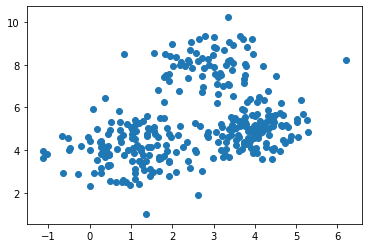

In [3]:
centers = [(1, 4), (3, 8), (4, 5)]
var1, var2, var3 = np.random.uniform(0.2, 1, 3)
x = list()
y = list()
n1, n2, n3 = np.random.randint(70, 150, 3)
for i in range(3):
    xs = np.random.normal(centers[i][0], eval(f'var{i+1}'), eval(f'n{i+1}'))
    ys = np.random.normal(centers[i][1], eval(f'var{i+1}'), eval(f'n{i+1}'))
    xs = [round(xi, 2) for xi in xs]
    ys = [round(yi, 2) for yi in ys]
    x.extend(xs)
    y.extend(ys)
    
fig, ax = plt.subplots(figsize=(10, 10))
_ = ax.scatter(x, y)

with open('k_means_data.txt', 'w') as file:
    for xi, yi in zip(x, y):
        file.write(f'{xi} {yi}\n')

In [12]:
import sys

input_file = 'k_means_data.txt' # sys.argv[1]
output_path = 'centroids' # sys.argv[2]

points = sc.textFile(input_file).map(lambda line: [float(v) for v in line.split()]) \
    .zipWithIndex().map(lambda v: (v[1], v[0]))
points.persist()

n_centroids = 3
x_min, y_min = points.values().min()
x_max, y_max = points.values().max()
x_centers = np.random.uniform(x_min, x_max, size=n_centroids)
y_centers = np.random.uniform(x_min, x_max, size=n_centroids)

centroids = sc.parallelize(np.array(list(zip(x_centers, y_centers)))) \
    .zipWithIndex().map(lambda v: (v[1], v[0]))


def j(x1, y1, x2, y2):
    return pow(x1 - x2, 2) + pow(y1 - y2, 2)


# https://stackoverflow.com/questions/38828139/spark-cartesian-product/38831748#38831748
def compute_assignments(points, centroids):
    n_points = points.count()
    indices = sc.parallelize([(i,j) for i in range(n_points) for j in range(n_centroids)])
    joined1 = indices.join(points).map(lambda v: (v[1][0], (v[0], v[1][1])))
    joined2 = joined1.join(centroids).map(lambda v: ((v[1][0][0], v[0]), (v[1][0][1], v[1][1])))
    distances = joined2.mapValues(lambda p: j(p[0][0], p[0][1], p[1][0], p[1][1]))

    assignments = distances.map(lambda p: (p[0][0], (p[0][1], p[1]))).groupByKey() \
        .map(lambda v: (v[0], pd.DataFrame(v[1]).set_index(0)[1].argmin()))
    return assignments

def update_centroids(points, assignments):
    return assignments.join(points).values().groupByKey() \
        .map(lambda v: (v[0], np.array(list(v[1])).mean(axis=0)))

def compute_j(points, centroids, assignments):
    return assignments.map(lambda v: (v[1], v[0])).join(centroids).values().join(points) \
        .map(lambda v: j(v[1][0][0], v[1][0][1], v[1][1][0], v[1][1][1])).reduce(lambda v1, v2: v1+v2)


last_j = None
done = False

iteration = 0
while not done:
    print(f'Iteration: {iteration}')
    iteration += 1
    assignments = compute_assignments(points, centroids)
    centroids = update_centroids(points, assignments)
    this_j = compute_j(points, centroids, assignments)
    if this_j == last_j:
        done = True
    else:
        last_j = this_j
        
print('Computed centroids:')
print(centroids.values().take(5))

print('Real centroids: ')
print(centers)        

df_data = list(assignments.sortByKey(ascending=True).collect())
df_assignments = pd.DataFrame(df_data).set_index(0)

centroids.saveAsTextFile(output_path)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8


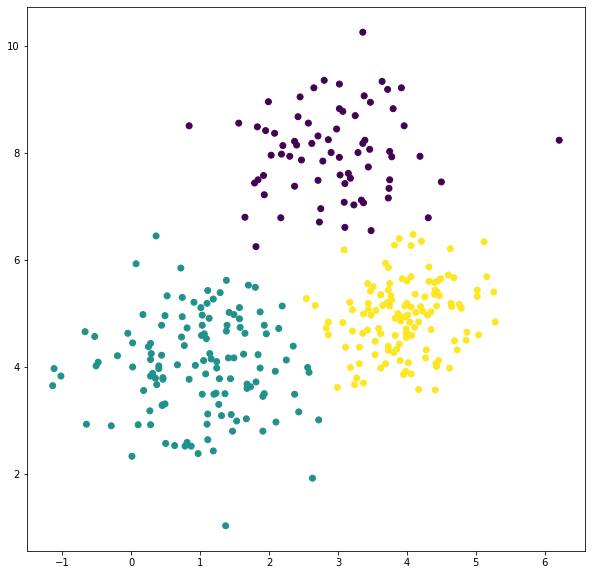

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))
_ = ax.scatter(x, y, c=df_assignments[1])